## Signal Quantization

Quantize the given data source "Dat_2.mat" using both uniform quantization and Lloyd–Max quantization method.  
   >1)quantize into 16 and 64 levels  
    2)boundary = (-6, 6)  
    3)Analyze the quantization noise.  

In [55]:
import numpy as np
import scipy.io as sio
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import warnings  
warnings.filterwarnings('ignore')

#### Load the data file into numpy array

In [113]:
mat_content = sio.loadmat("Dat_2.mat")
data = mat_content['X'].reshape(10000)
bound = (-6, 6)

#### Have a look at the data

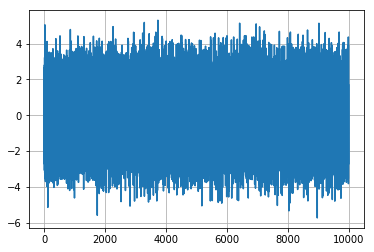

In [114]:
plt.plot(data)
plt.grid()

#### Define the distortion function
(Mean square error)

In [4]:
def distortion(x, y):
    return(((y - x) ** 2).sum())

### Uniform quantization

In [5]:
def uniform_quanti(data, n, bound=(min(data), max(data))):
    data[data < bound[0]] = bound[0]
    data[data > bound[1]] = bound[1]
    
    delta = (bound[1] - bound[0])/n
    return(delta * ((data/delta + 1/2) // 1))

In [54]:
uni_quan16 = uniform_quanti(data, 16, (-6, 6))
uni_quan64 = uniform_quanti(data, 64, (-6, 6))

uni_distortion16 = distortion(data, uni_quan16)
uni_distortion64 = distortion(data, uni_quan64)

print("4-bit distortion:", uni_distortion16)
print("6-bit distortion:", uni_distortion64)

4-bit distortion: 463.4149198485427
6-bit distortion: 29.585591761753818


### Lloyd–Max quantization
Given the fixed code length(4/6-bit), the optimization goal is to minimize the distortion.  
The distortion $D(b, y)$ is continuous and differentiable with respect to both $b$ and $y$.  
Thus the miminum points satisfies:  
$\displaystyle \frac{\partial D}{\partial b_k} = 0 \Rightarrow b_k = \frac{y_{k-1} + y_k}{2}$  
$\displaystyle \frac{\partial D}{\partial y_k} = 0 \Rightarrow y_k = \frac{\int_{b_k}^{b_{k+1}} x \cdot \text{pdf}(x)dx}{\int_{b_k}^{b_{k+1}}\text{pdf}(x)dx}$  
Iterate to optimize the result.

#### Estimate the PDF from the sample data

In [7]:
def count_freq(data, n=10000, bound=(min(data), max(data))):
    delta = (bound[1] - bound[0]) / n
    freq = np.array([(((i*delta + bound[0]) <= data) & (data < ((i+1)*delta + bound[0]))).sum() for i in range(n)])
    return((freq/data.size, delta))

In [57]:
n = 50
(freq, delta) = count_freq(data, n, bound)
x = np.linspace(bound[0], bound[1], n)

# Using a cubic interpolation to approximate the PDF
# Curve fitting should be a better approach, but considering
# the programming complexity, leave it for another time.
pdf = interp1d(x, freq/delta, kind="cubic")
xpdf = interp1d(x, x*freq/delta, kind="cubic")


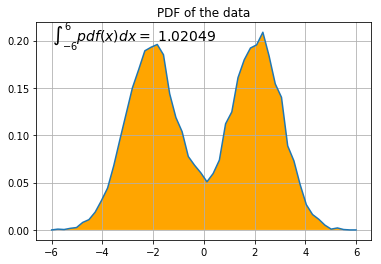

In [81]:
plt.plot(x, pdf(x), '-', label='PDF')
plt.fill_between(x, pdf(x), 0, facecolor='orange')
plt.title("PDF of the data")
plt.text(-6, 0.2, "$\int_{-6} ^{6} pdf(x)dx = $ %.5f"%(integrate.quad(pdf, -6, 6)[0]), fontsize=14)
plt.grid()

In [86]:
def LM_iterate(b, y, n, pdf, xpdf):
    B_Y = []
    for _ in range(max(n) + 1):
        b[1 : -1] = (y[1:] + y[0:-1]) / 2

        for i in range(y.size):
            num, err = integrate.quad(xpdf, b[i], b[i+1])
            den, err = integrate.quad(pdf, b[i], b[i+1])
            y[i] = num/den
        if(_ in n): B_Y.append([b.copy(), y.copy()])
    return(B_Y)

In [87]:
def quantify(data, b, y):
    data[data < b[0]] = b[0]
    data[data > b[-1]] = b[-1]
    
    q_data = np.array([y[np.argmax(b >= data[i]) - 1] for i in range(data.size)])
    return(q_data.copy())

In [88]:
y16 = np.sort(((np.random.rand(16)- 1/2) * 2 * 6))
b16 = np.zeros(16 + 1)
y64 = np.sort(((np.random.rand(64)- 1/2) * 2 * 6))
b64 = np.zeros(64 + 1)
b16[0] = -6
b16[-1] = 6
b64[0] = -6
b64[-1] = 6

n = [5, 10, 20, 30, 40, 50, 60, 80, 100]
B_Y16 = LM_iterate(b16, y16, n, pdf, xpdf)
B_Y64 = LM_iterate(b64, y64, n, pdf, xpdf)

In [89]:
q_data16 = []
q_data64 = []

for b, y in B_Y16:
    q_data16.append(quantify(data, b, y))
for b, y in B_Y64:
    q_data64.append(quantify(data, b, y))

distortions16 = []
distortions64 = []
for qd in q_data16:
    distortions16.append(distortion(data, qd))
for qd in q_data64:
    distortions64.append(distortion(data, qd))


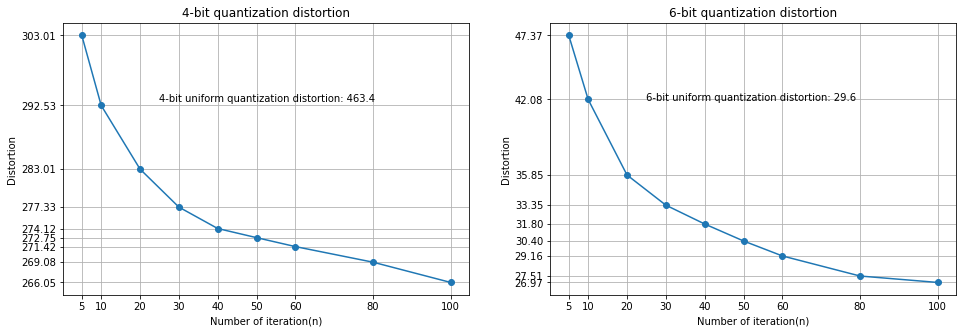

In [122]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(n, distortions16, '-o')
plt.title("4-bit quantization distortion")
plt.xticks(n)
plt.yticks(distortions16)
plt.ylabel("Distortion")
plt.xlabel("Number of iteration(n)")
plt.text(25, 293, "4-bit uniform quantization distortion: %.1f"%(uni_distortion16))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(n, distortions64, '-o')
plt.title("6-bit quantization distortion")
plt.xticks(n)
plt.yticks(distortions64)
plt.ylabel("Distortion")
plt.xlabel("Number of iteration(n)")
plt.text(25, 42, "6-bit uniform quantization distortion: %.1f"%(uni_distortion64))
plt.grid()

#plt.savefig("distortion.png", dpi=200)